# Plotting Tiles

## Objectives

Introduce several different methods for plotting ECCO v4 fields that are stored as tiles in `Datasets` or `DataArrays`.  Emphasis is placed on fields stored on the ECCO v4 native llc90 grid and loaded from NetCDF tile files.

## Introduction

*"Over the years many different plotting modules and packages have been developed for Python. For most of that time there was no clear favorite package, but recently matplotlib has become the most widely used. Nevertheless, many of the others are still available and may suit your tastes or needs better. Some of these are interfaces to existing plotting libraries while others are Python-centered new implementations.*
-- from : https://wiki.python.org/moin/NumericAndScientific/Plotting


The link above profiles a long list of Python tools for plotting.  In this tutorial we use just two libraries, *matplotlib* and *Cartopy*.

> Note: In this tutorial you will need to have downloaded monthly SSH, THETA, and SALT for the year 2000. The ShortNames of the datasets needed are **ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4** and **ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4**. You will also need the [grid file](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Loading_the_ECCOv4_native_model_grid_parameters.html).

### matplotlib
*"Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. Matplotlib can be used in Python scripts, the Python and IPython shell, the jupyter notebook, web application servers, and four graphical user interface toolkits."*

*"For simple plotting the pyplot module provides a MATLAB-like interface, particularly when combined with [Juypter Notebooks]. For the power user, you have full control of line styles, font properties, axes properties, etc, via an object oriented interface or via a set of functions familiar to MATLAB users."*
-- from https://matplotlib.org/index.html

Matplotlib and pyplot even have a tutorial: https://matplotlib.org/users/pyplot_tutorial.html

### Cartopy

"Cartopy is a Python package designed for geospatial data processing in order to produce maps and other geospatial data analyses."

Cartopy makes use of the powerful PROJ.4, NumPy and Shapely libraries and includes a programmatic interface built on top of Matplotlib for the creation of publication quality maps.

Key features of cartopy are its object oriented projection definitions, and its ability to transform points, lines, vectors, polygons and images between those projections.

You will find cartopy especially useful for large area / small scale data, where Cartesian assumptions of spherical data traditionally break down. If you’ve ever experienced a singularity at the pole or a cut-off at the dateline, it is likely you will appreciate cartopy’s unique features!"*

-- from https://scitools.org.uk/cartopy/docs/latest/


## The default orientation of the lat-lon-cap tile fields

Before we begin plotting ECCOv4 fields on the native llc90 model grid we are reminded how how the 13 tiles are oriented with respect to their "local" **x** and **y** and with respect to each other.

![llc90 tile layout](../figures/llc90_0.png)

Tiles 7-12 are rotated 90 degrees counter-clockwise relative to tiles 0-5.

> **Note:**  *The rotated orientation of tiles 7-12 presents some complications but don't panic!  The good news is that you don't need to reorient tiles to plot them.*

## Plotting single tiles using ``imshow``, ``pcolormesh``, and ``contourf``

First, let's load the all 13 tiles for sea surface height and the model grid parameters.

> **Note:** The notebook uses the `ecco_access` library to download (or direct access in the AWS Cloud) the ECCO output. It is recommended to set up `ecco_access` [in your Python path](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#Setting-up-ecco_access), if you haven't already.

In [1]:
import numpy as np
import sys
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')

import ecco_access as ea

# indicate mode of access
# options are:
# 'download': direct download from internet to your local machine
# 'download_ifspace': like download, but only proceeds 
#                     if your machine have sufficient storage
# 's3_open': access datasets in-cloud from an AWS instance
# 's3_open_fsspec': use jsons generated with fsspec and 
#                   kerchunk libraries to speed up in-cloud access
# 's3_get': direct download from S3 in-cloud to an AWS instance
# 's3_get_ifspace': like s3_get, but only proceeds if your instance 
#                   has sufficient storage
access_mode = 'download_ifspace'

In [2]:
# load some useful cartopy routines
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# and a new matplotlib routine 
import matplotlib.path as mpath

In [3]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [4]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to /Downloads/ECCO_V4r4_PODAAC
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

# # for access_mode = 's3_open_fsspec', need to specify the root directory 
# # containing the jsons
# jsons_root_dir = join('/efs_ecco','mzz-jsons')

In [5]:
## open ECCO datasets needed for the tutorial

ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"]

ds_dict = ea.ecco_podaac_access(ShortNames_list,\
                                              StartDate='2000-01',EndDate='2000-12',\
                                              download_root_dir=ECCO_dir,\
                                              max_avail_frac=0.5)

ecco_grid = ds_dict[ShortNames_list[0]]
ds_SSH = ds_dict[ShortNames_list[1]]
ds_temp_sal = ds_dict[ShortNames_list[2]]

## select only *surface* temperature and salinity (SST and SSS)
ds_SST_SSS = ds_temp_sal.isel(k=0)


## Copy ecco_ds from ecco_grid dataset
ecco_ds = ecco_grid.copy()
## Add SSH, SST, and SSS variables to ecco_ds
ecco_ds['SSH'] = ds_SSH['SSH']
ecco_ds['SST'] = ds_SST_SSS['THETA']
ecco_ds['SSS'] = ds_SST_SSS['SALT']

## Load ecco_ds into memory
ecco_ds = ecco_ds.compute()

In [6]:
ecco_ds

<xarray.Dataset> Size: 104MB
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
              k_p1: 51, tile: 13, nb: 4, nv: 2, time: 12)
Coordinates: (12/21)
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    ...       ...
    Zu       (k_u) float32 200B -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    Zl       (k_l) float32 200B 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    XC_bnds  (tile, j, i, nb) float32 2MB -115.0 -115.0 -107.9 ... -115.0 -108.5
    YC_bnds  (tile, j, i, nb) float32 2MB -88.18 -88.32 -88.3 ... -88.18 -88.16
    Z_bnds   (k, nv) float32 400B 0.0 -10.0 -10.0 ... -5.678e+03 -6.134e+03
  * time     (time) datetime64[ns] 96B 2000-01-16T12:00:00 ... 2000-12-16T12:...
Dimensions without coordinates: nb, nv
Data variables: (12/24)
    CS       (tile, j, i) float32 421kB 0.06158 0.06675 ... -0.9854 -0.9984
    SN       (tile, j, i) float32 421kB -0.9981 -0.9978 ... -0.1705 -0.05718
    rA       (tile, j, i) float32 421kB 3.623e+08 3.633e+08 ... 3.611e+08
    dxG      (tile, j_g, i) float32 421kB 1.558e+04 1.559e+04 ... 2.314e+04
    dyG      (tile, j, i_g) float32 421kB 2.321e+04 2.327e+04 ... 1.558e+04
    Depth    (tile, j, i) float32 421kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...       ...
    maskC    (k, tile, j, i) bool 5MB False False False ... False False False
    maskW    (k, tile, j, i_g) bool 5MB False False False ... False False False
    maskS    (k, tile, j_g, i) bool 5MB False False False ... False False False
    SSH      (time, tile, j, i) float32 5MB nan nan nan nan ... nan nan nan nan
    SST      (time, tile, j, i) float32 5MB nan nan nan nan ... nan nan nan nan
    SSS      (time, tile, j, i) float32 5MB nan nan nan nan ... nan nan nan nan
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

### Plotting a single tile with ``imshow``

First we'll plot the average SSH for the first month (Jan 2000) on tiles 3, 7, and 8 using the basic `imshow` routine from *pyplot*.  We are plotting these three different tiles to show that these lat-lon-cap tiles all have a different orientation in $x$ and $y$.

> **Note:** *The **origin='lower'** argument to `imshow` is required to make the $y$ origin at the bottom of the plot.*

#### Tile 2 (Northeast Atlantic)

Text(0, 0.5, 'y -->')

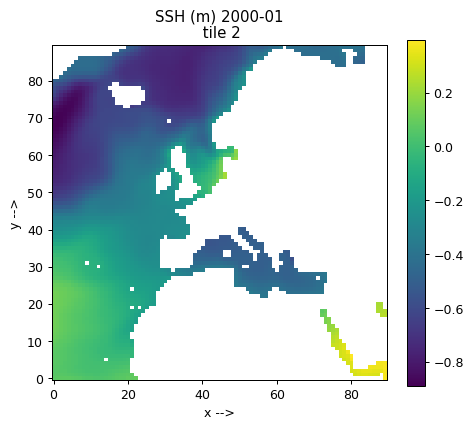

In [7]:
plt.figure(figsize=(6,5), dpi= 90)

# Step 1, select the tile to plot using the **.isel( )** syntax.  
tile_to_plot = ecco_ds.SSH.isel(tile=2, time=0)
tile_to_plot= tile_to_plot.where(ecco_ds.hFacC.isel(tile=2,k=0) !=0, np.nan)

# Step 2, use plt.imshow() 
plt.imshow(tile_to_plot, origin='lower');

# Step 3, add colorbar, title, and x and y axis labels
plt.colorbar()
plt.title('SSH (m) ' + str(ecco_ds.time[0].values)[0:7] + '\n tile 2')
plt.xlabel('x -->')
plt.ylabel('y -->')

Tiles 0-5 are by default in a quasi-lat-lon orientation.  +$x$ is to the east and +$y$ is to the north.

#### Tile 6 (the Arctic cap)

This time we'll plot the Arctic cap tile 6.  Notice the layout of the Arctic cap tile in $x$ and $y$.  We'll follow the same procedure for plotting except we'll use LaTeX to add arrows in the $x$ and $y$ axis labels (for fun).

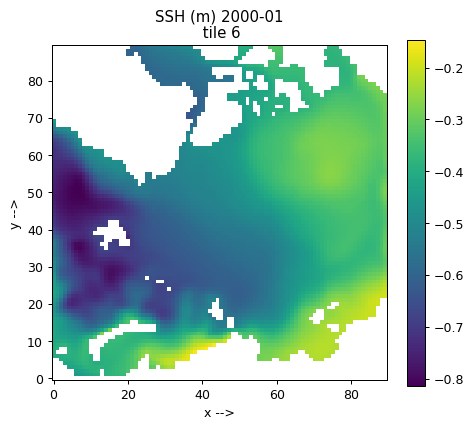

In [8]:
plt.figure(figsize=(6,5), dpi= 90)

# Step 1, select the tile to plot using the **.isel( )** syntax.  
tile_to_plot = ecco_ds.SSH.isel(tile=6, time=0)
tile_to_plot= tile_to_plot.where(ecco_ds.hFacC.isel(tile=6,k=0) !=0, np.nan)

# Step 2, use plt.imshow() 
plt.imshow(tile_to_plot, origin='lower');

# Step 3, add colorbar, title, and x and y axis labels
plt.colorbar()
plt.title('SSH (m) ' + str(ecco_ds.time[0].values)[0:7] + '\n tile 6')
plt.xlabel('x -->');
plt.ylabel('y -->');

Because tile 6 is the Arctic cap, $x$ and $y$ do not map to east and west throughout the domain.

#### Tile 7 (N. Pacific / Bering Sea / Chukchi Sea)

For tiles 7-12 , positive $x$ is southwards and positive $y$ is eastwards.

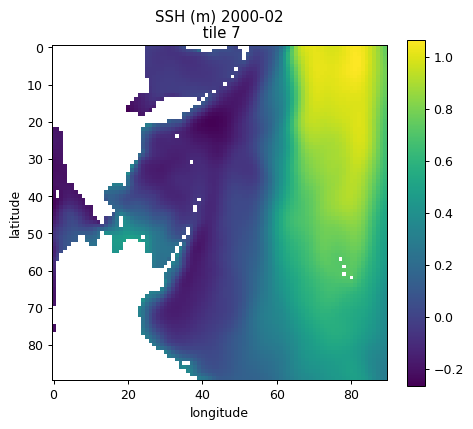

In [9]:
plt.figure(figsize=(6,5), dpi= 90)

# pull out lats and lons
tile_num=7
tile_to_plot = ecco_ds.SSH.isel(tile=tile_num, time=1)
tile_to_plot= tile_to_plot.where(ecco_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

plt.imshow(tile_to_plot)
plt.colorbar()
plt.title('SSH (m) ' + str(ecco_ds.time[1].values)[0:7] + '\n tile ' + str(tile_num))
plt.xlabel('longitude');
plt.ylabel('latitude');

Tiles 7-12 are are also in a quasi-lat-lon orientation except that +$x$ is roughly south and +$y$ is roughly east.

### Plotting a single tile with ``pcolor`` and ``contourf``

The `pcolor` and `contourf` routines allows us to add latitude and longitude to the figure.  Because SSH is a 'c' point variable, its lat/lon coordinates are *YC* and *XC*

We can't plot the Arctic cap tile with pcolor and contourf using latitude and longitude for the plot x and y axes because of the singularity at the pole and the 360 wrapping in longitude.  

Instead, we will demonstrate ``pcolor`` and ``contourf`` for tile 2.

#### Tile 2 (Northeast N. Atlantic)

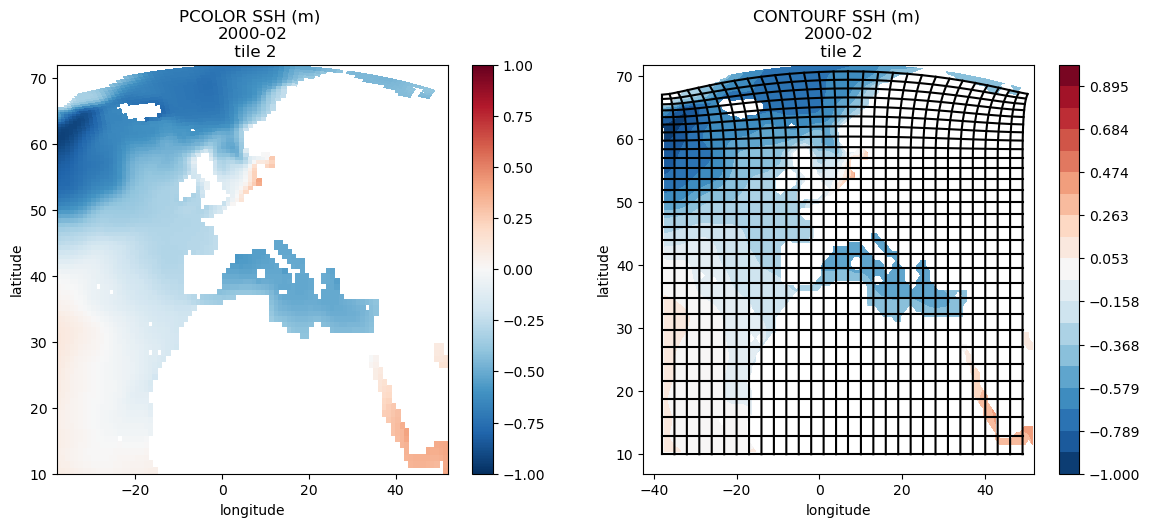

In [10]:
fig=plt.figure(figsize=(10, 10))

tile_num=2
time_ind=1

# pull out lats and lons
lons = ecco_ds.XC.sel(tile=tile_num)
lats = ecco_ds.YC.sel(tile=tile_num)
tile_to_plot = ecco_ds.SSH.isel(tile=tile_num, time=time_ind)

# mask to NaN where hFacC is == 0 
# syntax is actually "keep where hFacC is not equal to zero"
tile_to_plot= tile_to_plot.where(ecco_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

# create subplot for pcolor
fig = plt.subplot(221)

# use pcolor with 'lons' and 'lats' for the plot x and y axes 
plt.pcolor(lons, lats, tile_to_plot, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()
plt.title('PCOLOR SSH (m) \n' + str(ecco_ds.time[time_ind].values)[0:7] + '\n tile ' + str(tile_num))
plt.xlabel('longitude')
plt.ylabel('latitude')

# create subplot for contourf
fig=plt.subplot(222)

# use contourf with 'lons' and 'lats' for the plot x and y axes 
plt.contourf(lons, lats, tile_to_plot, np.linspace(-1,1, 20,endpoint=True), cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('CONTOURF SSH (m) \n' + str(ecco_ds.time[time_ind].values)[0:7] + '\n tile ' + str(tile_num))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()

# plot every 3rd model grid line to show how tile 3 is 'warped' above around 60N
plt.plot(ecco_ds.XG.isel(tile=tile_num)[::3,::3], ecco_ds.YG.isel(tile=tile_num)[::3,::3],'k-')
plt.plot(ecco_ds.XG.isel(tile=tile_num)[::3,::3].T, ecco_ds.YG.isel(tile=tile_num)[::3,::3].T,'k-')

# push the subplots away from each other a bit
plt.subplots_adjust(bottom=0, right=1.2, top=.9)

#### Tile 7 (N. Pacific / Bering Sea / Chukchi Sea)

If longitude and latitude are passed as the 'x' and 'y' arguments to `pcolor` and `contourf` then the fields will be oriented geographically.

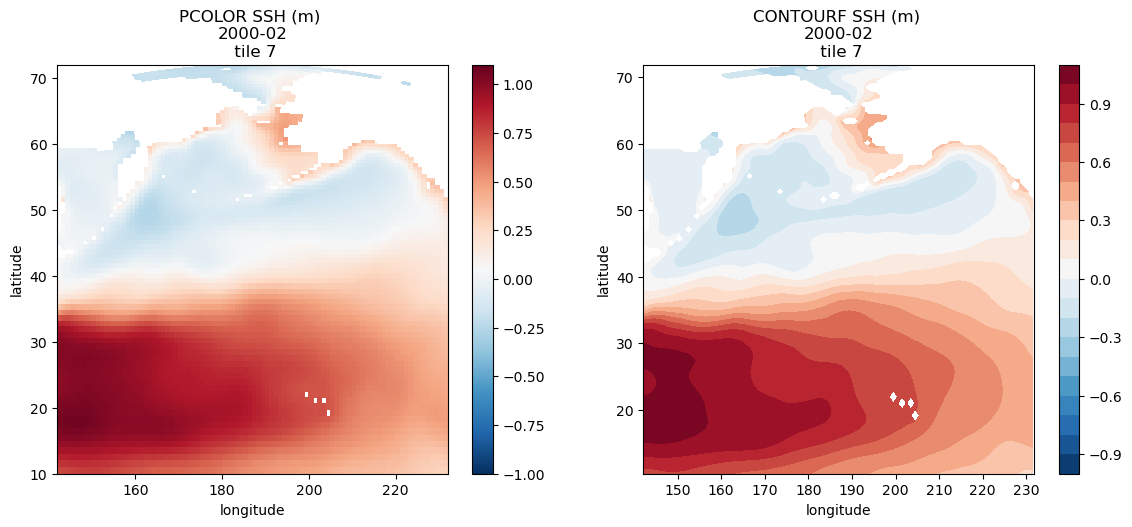

In [11]:
fig=plt.figure(figsize=(10, 10))

tile_num=7
time_ind=1

# pull out lats and lons
lons = np.copy(ecco_ds.XC.sel(tile=tile_num))

# we must convert the longitude coordinates from 
# [-180 to 180] to [0 to 360] 
# because of the crossing of the international date line.
lons[lons < 0] = lons[lons < 0]+360

lats = ecco_ds.YC.sel(tile=tile_num)
tile_to_plot = ecco_ds.SSH.isel(tile=tile_num, time=time_ind)

# mask to NaN where hFacC is == 0 
# syntax is actually "keep where hFacC is not equal to zero"
tile_to_plot= tile_to_plot.where(ecco_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

# create subplot for pcolor
fig = plt.subplot(221)

# use pcolor with 'lons' and 'lats' for the plot x and y axes 
plt.pcolor(lons, lats, tile_to_plot, vmin=-1, vmax=1.1, cmap='RdBu_r')
plt.colorbar()
plt.title('PCOLOR SSH (m) \n' + str(ecco_ds.time[time_ind].values)[0:7] + '\n tile ' + str(tile_num))
plt.xlabel('longitude')
plt.ylabel('latitude')

# create subplot for contourf
fig=plt.subplot(222)

# use contourf with 'lons' and 'lats' for the plot x and y axes 
plt.contourf(lons, lats, tile_to_plot, np.linspace(-1,1.1,22,endpoint=True), cmap='RdBu_r', vmin=-1, vmax=1.1)
plt.title('CONTOURF SSH (m) \n' + str(ecco_ds.time[time_ind].values)[0:7] + '\n tile ' + str(tile_num))
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.colorbar()

# push the subplots away from each other a bit
plt.subplots_adjust(bottom=0, right=1.2, top=.9)

## Plotting fields from one tile using ``Cartopy``

The ``Cartopy`` package provides routines to make plots using different geographic projections.  We'll demonstrate plotting these three tiles again using *Cartopy*.

To see a list of ``Cartopy`` projections, see http://pelson.github.io/cartopy/crs/projections.html

### Geographic Projections (AKA: plate carrée)

``Cartopy`` works by transforming geographic coordintes (lat/lon) to new x,y coordinates associated with different projections.  The most familiar projection is the so-called geographic projection (aka plate carree).  When we plotted tiles using ``pcolor`` and ``contourf`` we were de-factor using the plate carree projection longitude and latitude were the 'x' and the 'y' of the plot.  

With ``Cartopy`` we can make similar plots in the plate carree projection system and also apply some cool extra details, like land masks. 

We'll demonstrate on tiles 2 and 7 (again skipping tile 6 (Arctic cap) because we cannot use geographic coordinates as x and y when there is a polar singularity and 360 degrees of longitude.

#### Tile 2 with plate carree

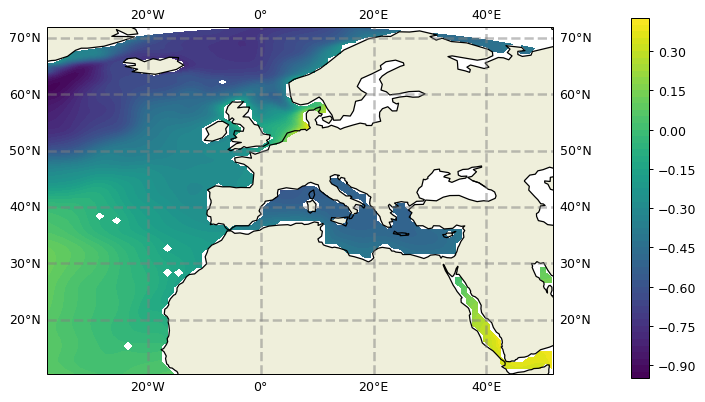

In [12]:
tile_num=2
time_ind=1

lons = ecco_ds.XC.isel(tile=tile_num)
lats = ecco_ds.YC.isel(tile=tile_num)

tile_to_plot = ecco_ds.SSH.isel(tile=tile_num, time=time_ind)
# mask to NaN where hFacC is == 0 
# syntax is actually "keep where hFacC is not equal to zero"
tile_to_plot= tile_to_plot.where(ecco_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

fig = plt.figure(figsize=(10,5), dpi= 90)

# here is where you specify what projection you want to use
ax = plt.axes(projection=ccrs.PlateCarree())

# here is here you tell Cartopy that the projection 
# of your 'x' and 'y' are geographic (lons and lats)
# and that you want to transform those lats and lons 
# into 'x' and 'y' in the projection
cf = plt.contourf(lons, lats, tile_to_plot, 60,
                  transform=ccrs.PlateCarree());

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--');
ax.coastlines()
ax.add_feature(cfeature.LAND)

# add separate axes for colorbar (to ensure it doesn't overlap main plot)
cbar_ax = fig.add_axes([0.88,0.1,0.02,0.8])
plt.colorbar(cf,ax=ax,cax=cbar_ax)

Other features we could have added include:


~~~
cartopy.feature.BORDERS
	Country boundaries.

cartopy.feature.COASTLINE
	Coastline, including major islands.

cartopy.feature.LAKES
	Natural and artificial lakes.

cartopy.feature.LAND
	Land polygons, including major islands.

cartopy.feature.OCEAN
	Ocean polygons.

cartopy.feature.RIVERS
	Single-line drainages, including lake centerlines.
~~~



Let's add geographic borders just to demonstrate how extra features can be added to a ``Cartopy`` map

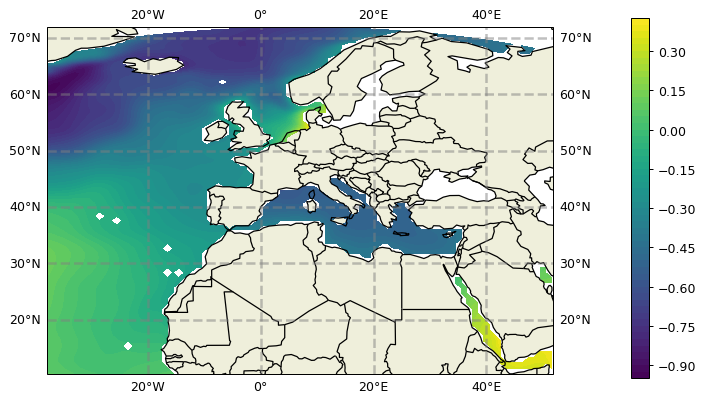

In [13]:
fig = plt.figure(figsize=(10,5), dpi= 90)

# here is where you specify what projection you want to use
ax = plt.axes(projection=ccrs.PlateCarree())

# here is here you tell Cartopy that the projection 
# of your 'x' and 'y' are geographic (lons and lats)
# and that you want to transform those lats and lons 
# into 'x' and 'y' in the projection
cf = plt.contourf(lons, lats, tile_to_plot, 60,
                  transform=ccrs.PlateCarree());

gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                  draw_labels=True,
                  linewidth=2, color='gray', \
                  alpha=0.5, linestyle='--');
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS)

# add separate axes for colorbar (to ensure it doesn't overlap main plot)
cbar_ax = fig.add_axes([0.88,0.1,0.02,0.8])
plt.colorbar(cf,ax=ax,cax=cbar_ax)

#### Tile 7 with plate carree

To use the plate carree projection across the international date line specify the *central_longitude=-180* argument when defining the projection and for creating the gridlines. (see https://stackoverflow.com/questions/13856123/setting-up-a-map-which-crosses-the-dateline-in-cartopy)

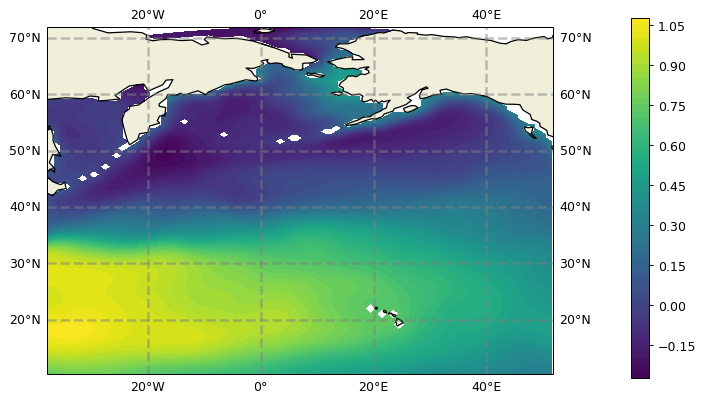

In [14]:
tile_num=7
time_ind=1

# pull out lats and lons
lons = np.copy(ecco_ds.XC.sel(tile=tile_num))

# we must convert the longitude coordinates from 
# [-180 to 180] to [0 to 360] 
# because of the crossing of the international date line.
lons[lons < 0] = lons[lons < 0]+360
lats = ecco_ds.YC.isel(tile=tile_num)

tile_to_plot = ecco_ds.SSH.isel(tile=tile_num, time=time_ind)
# mask to NaN where hFacC is == 0 
# syntax is actually "keep where hFacC is not equal to zero"
tile_to_plot= tile_to_plot.where(ecco_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

fig = plt.figure(figsize=(10,5), dpi= 90)

# here is where you specify what projection you want to use
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))

# here is here you tell Cartopy that the projection of your 'x' and 'y' are geographic (lons and lats)
# and that you want to transform those lats and lons into 'x' and 'y' in the projection
cf = plt.contourf(lons, lats, tile_to_plot, 60,
                  transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=-180), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--');
ax.coastlines()
ax.add_feature(cfeature.LAND)

# add separate axes for colorbar (to ensure it doesn't overlap main plot)
cbar_ax = fig.add_axes([0.88,0.1,0.02,0.8])
plt.colorbar(cf,ax=ax,cax=cbar_ax)

### Polar Stereographic Projection

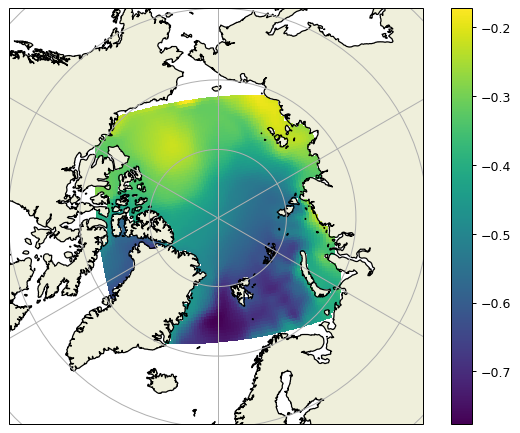

In [15]:
tile_num=6
time_ind=1

# use lower-left grid corner coordinates for flat pcolormesh shading --
# this avoids some funky effects when plot is transformed into 
# the polar stereographic projection
lon_corners = ecco_ds.XG.isel(tile=tile_num)
lat_corners = ecco_ds.YG.isel(tile=tile_num)


tile_to_plot = ecco_ds.SSH.isel(tile=tile_num, time=time_ind)

# mask to NaN where hFacC is == 0 
# syntax is actually "keep where hFacC is not equal to zero"
tile_to_plot = tile_to_plot.where(ecco_ds.hFacC.isel(tile=tile_num,k=0) !=0, \
                       np.nan)

plt.figure(figsize=(8,6), dpi= 90)


# Make a new projection, time of class "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))

# here is here you tell Cartopy that the projection 
# of your 'x' and 'y' are geographic (lons and lats)
# and that you want to transform those lats and lons 
# into 'x' and 'y' in the projection
plt.pcolormesh(lon_corners, lat_corners, tile_to_plot[:-1,:-1],
               transform=ccrs.PlateCarree(),shading='flat');

# plot land
ax.add_feature(cfeature.LAND)
ax.gridlines()
ax.coastlines()
plt.colorbar()

# Limit the map to 60 degrees latitude and above.
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

#ax.set_boundary(circle, transform=ax.transAxes)

## Plotting all 13 tiles simultaneously: No Projection

### Plotting all 13 tiles with `plot_tiles`

The `plot_tiles` routine in the ``ecco_v4_py`` package makes plots of all 13 tiles of a field.  By default the routine will plot all of the tiles in the lat-lon-cap layout shown earlier.   

This routine will accept ``numpy arrays`` of dimension 13x90x90 or 2D slices of DataArrays with the same 13x90x90 dimension.  

There are several additional arguments which we can access using the ``help`` command.  Take a second to familiarize yourself with some of them.

In [16]:
help(ecco.plot_tiles)

Help on function plot_tiles in module ecco_v4_py.tile_plot:

plot_tiles(tiles, cmap=None, layout='llc', rotate_to_latlon=False, Arctic_cap_tile_location=2, show_colorbar=False, show_cbar_label=False, show_tile_labels=True, cbar_label='', fig_size=9, less_output=True, **kwargs)
    Plots the 13 tiles of the lat-lon-cap (LLC) grid
    
    Parameters
    ----------
    tiles : numpy.ndarray or dask.array.core.Array or xarray.core.dataarray.DataArray
        an array of n=1..13 tiles of dimension n x llc x llc 
    
            - If *xarray DataArray* or *dask Array* tiles are accessed via *tiles.sel(tile=n)*
            - If *numpy ndarray* tiles are acceed via [tile,:,:] and thus n must be 13.
    
    cmap : matplotlib.colors.Colormap, optional
        see plot_utils.assign_colormap for default
        a colormap for the figure
    
    layout : string, optional, default 'llc'
        a code indicating the layout of the tiles
    
        :llc:    situates tiles in a fan-like manner wh

We've seen this routine used in a few earlier tutorials.  We'll provide some additional examples below:

#### Default 'native grid' layout

In [17]:
# optional arguments:
#   cbar       - show the colorbar
#   cmin, cmax - color range min and max
#   fsize      - figure size in inches

# pull out surface salinity
tmp_plt = ecco_ds.SSS.isel(time=3)

# mask to NaN where hFacC is == 0 
# syntax is actually "keep where hFacC is not equal to zero"
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) != 0, np.nan)

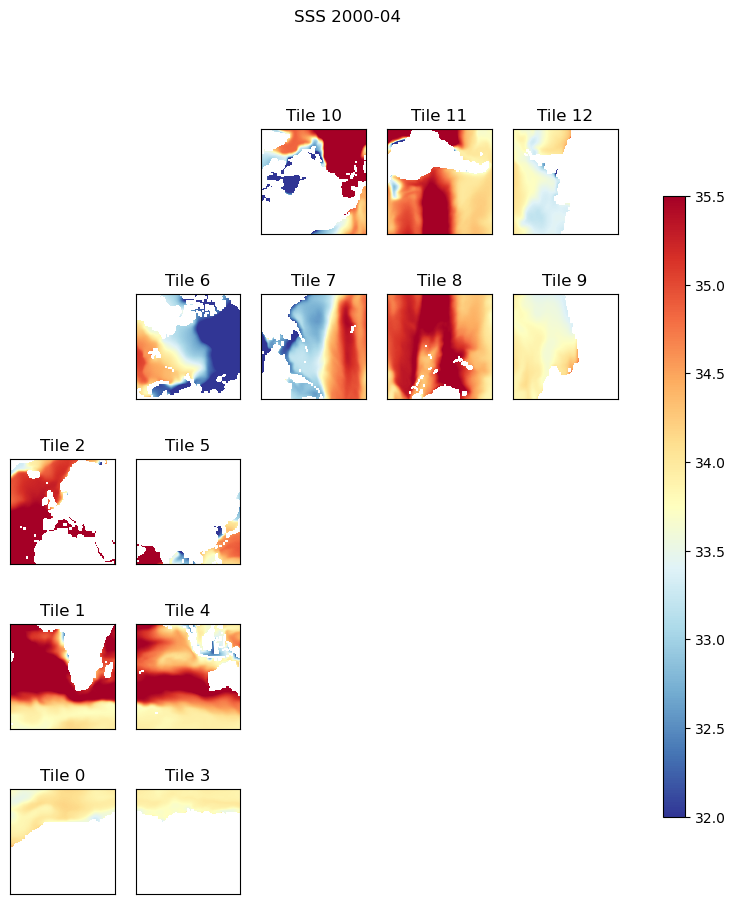

In [18]:
ecco.plot_tiles(tmp_plt, \
                cmin=32, \
                cmax=35.5, \
                cmap='RdYlBu_r', \
                show_colorbar=True);

# use `suptitle` (super title) to make a title over subplots.
plt.suptitle('SSS ' + str(ecco_ds.time[3].values)[0:7]);

#### lat-lon layout

Another option of `plot_tiles` is to show tiles 7-12 rotated and lined up tiles 0-5

> **Note:** *Rotation of tiles 7-13 is only for **plotting**.  These arrays are not rotated using this routine.  We'll show to how actually rotate these tiles in a later tutorial.*

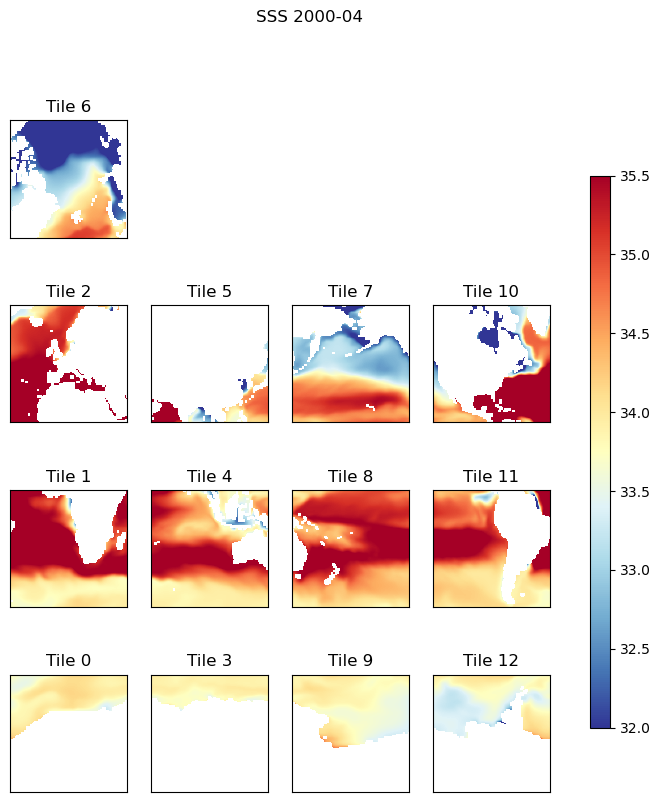

In [19]:
# optional arguments:
#   cbar       - show the colorbar
#   cmin, cmax - color range min and max
#   fsize      - figure size in inches

tmp_plt = ecco_ds.SSS.isel(time=3) 
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) != 0, np.nan)
ecco.plot_tiles(tmp_plt, \
                cmin=32, cmax=35.5, cmap='RdYlBu_r', \
                show_colorbar=True, fig_size=8,\
                layout='latlon', \
                rotate_to_latlon=True);

# use `suptitle` (super title) to make a title over subplots.
plt.suptitle('SSS ' + str(ecco_ds.time[3].values)[0:7]);

The version of `plot_tiles` is to remove the tile labels and put the titles together in a tight formation and sticks the Arctic tile over tile 10

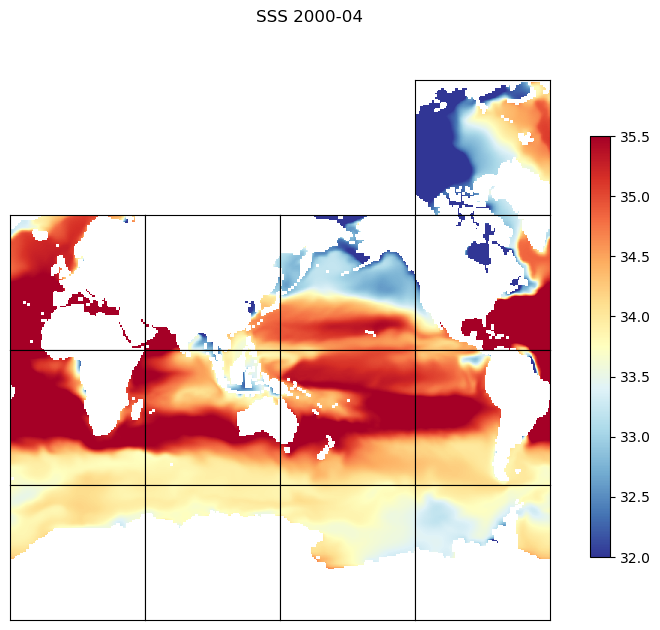

In [20]:
# optional arguments:
#   cbar       - show the colorbar
#   cmin, cmax - color range min and max
#   fsize      - figure size in inches

tmp_plt = ecco_ds.SSS.isel(time=3) 
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) != 0, np.nan)
ecco.plot_tiles(tmp_plt, cmin=32, cmax=35.5, cmap='RdYlBu_r', \
                show_colorbar=True, fig_size=8,\
               layout='latlon',rotate_to_latlon=True,\
               show_tile_labels=False, \
               Arctic_cap_tile_location=10)

# use `suptitle` (super title) to make a title over subplots.
plt.suptitle('SSS ' + str(ecco_ds.time[3].values)[0:7]);

 *Almost ready for the hyperwall!*


You can plot a subset of tiles using ``plot_tiles``, but you need to pass it a full xarray DataArray or Numpy array with 13 tiles, and the undesired tiles masked out.

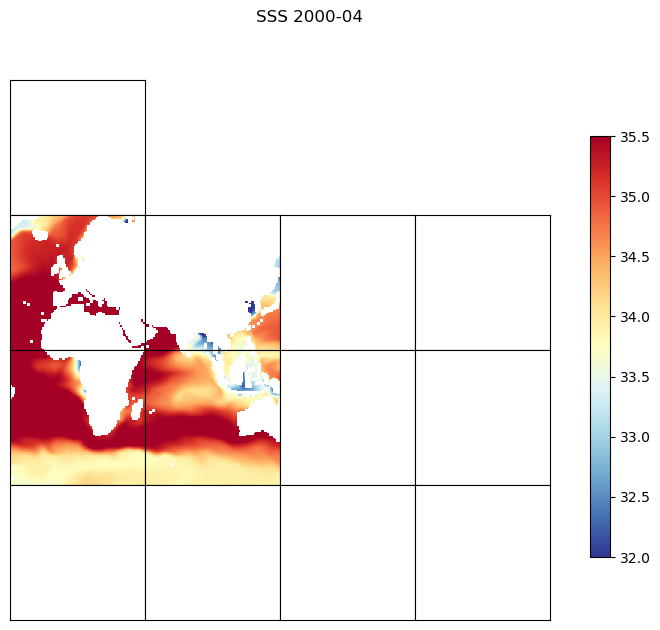

In [21]:
# optional arguments:
#   cbar       - show the colorbar
#   cmin, cmax - color range min and max
#   fsize      - figure size in inches

tmp_plt = ecco_ds.SSS.isel(time=3)
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) != 0, np.nan)
tiles_to_subset = [1,2,4,5]
# add dimensions to vector of tile numbers, so it will readily broadcast across grid
tile_to_broadcast = np.expand_dims(ecco_ds.tile.values,axis=(-2,-1))
# mask tiles not in tiles_to_subset with NaNs
tmp_plt_subset = tmp_plt.where(np.isin(tile_to_broadcast,tiles_to_subset),np.nan)

# select a subset of tiles
ecco.plot_tiles(tmp_plt_subset, cmin=32, cmax=35.5, \
                cmap='RdYlBu_r', show_colorbar=True, fig_size=8,\
                layout='latlon',rotate_to_latlon=True,\
                show_tile_labels=False)

# use `suptitle` (super title) to make a title over subplots.
plt.suptitle('SSS ' + str(ecco_ds.time[3].values)[0:7]);


## Plotting all 13 tiles with `plot_proj_to_latlon_grid`

Our routine `plot_proj_to_latlon_grid` takes `numpy` arrays or `DataArrays` with 13 tiles and creates global plots with one of three types of projections (passed as arguments to the function):
~~~
    projection_type : string, optional
        denote the type of projection, options include
            'robin' - Robinson
            'PlateCaree' - flat 2D projection
            'Mercator'
            'cyl' - Lambert Cylindrical
            'ortho' - Orthographic
            'stereo' - polar stereographic projection, see lat_lim for choosing
            'InterruptedGoodeHomolosi
~~~

Before plotting this routine interpolates the the filed onto a lat-lon grid (default resoution 0.25 degree) to conform with ``Cartopy's`` requirement that the fields to be transformed be on regular square grid.

There are only three argument required of `plot_proj_to_latlon_grid`, an array of longitudes, an array of latitudes, and an array of the field you wish to plot.  The arrays can be either numpy arrays or `DataArrays`.  

Let's again spend a second to look at the optional arguments available to us in this routine:

In [22]:
help(ecco.plot_proj_to_latlon_grid)

Help on function plot_proj_to_latlon_grid in module ecco_v4_py.tile_plot_proj:

plot_proj_to_latlon_grid(lons, lats, data, projection_type='robin', dx=0.25, dy=0.25, mapping_method='nearest_neighbor', radius_of_influence=112000, plot_type='pcolormesh', circle_boundary=False, cmap=None, cmin=None, cmax=None, user_lon_0=0, user_lat_0=None, lat_lim=50, parallels=None, show_coastline=True, show_colorbar=False, show_land=True, show_grid_lines=True, show_grid_labels=False, show_coastline_over_data=True, show_land_over_data=True, grid_linewidth=1, grid_linestyle='--', colorbar_label=None, subplot_grid=None, less_output=True, **kwargs)
    Plot a field of data from an arbitrary projection with lat/lon coordinates
    on a geographic projection after resampling it to a regular lat/lon grid.
    
    
    Parameters
    ----------
    lons, lats : numpy ndarray or xarray DataArrays, required
        the longitudes and latitudes of the data to plot
        
    data : numpy ndarray or xarray Data

plot_proj_to_latlon_grid(lons, lats, data, projection_type='robin', plot_type='pcolormesh', user_lon_0=-66, lat_lim=50, levels=20, cmap='jet', dx=0.25, dy=0.25, show_colorbar=False, show_grid_lines=True, show_grid_labels=True, subplot_grid=None, less_output=True, **kwargs)

### Robinson projection

First we'll demonstrate the Robinson projection interpolated to a 2x2 degree grid

_create_projection_axis: projection_type robin
_create_projection_axis: user_lon_0, user_lat_0 0 None
_create_projection_axis: parallels None
_create_projection_axis: lat_lim 50
Projection type:  robin


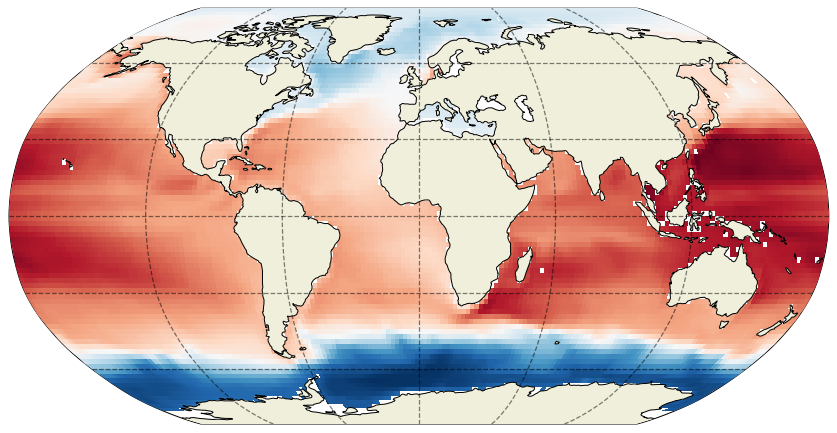

In [23]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ecco_ds.SSH.isel(time=1)
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) !=0)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC, \
                              ecco_ds.YC, \
                              tmp_plt, \
                              plot_type = 'pcolormesh', \
                              dx=2,\
                              dy=2, \
                              projection_type = 'robin',\
                              less_output = False);

Setting *lon_0* = 110 or -66 yield a global centering that is is more usesful for plotting ocean basins.

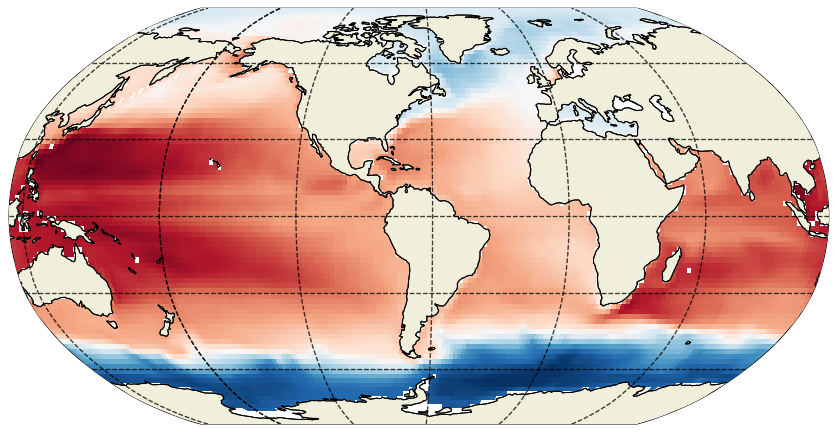

In [24]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ecco_ds.SSH.isel(time=1)
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) !=0)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC, 
                 ecco_ds.YC, 
                 tmp_plt,user_lon_0=-66,
                 plot_type = 'pcolormesh', dx=2,dy=2);

#### Cylindrical projection

Try the Cylindrical Projection with an interpolated lat-lon resolution of 0.25 degrees and pcolormesh.

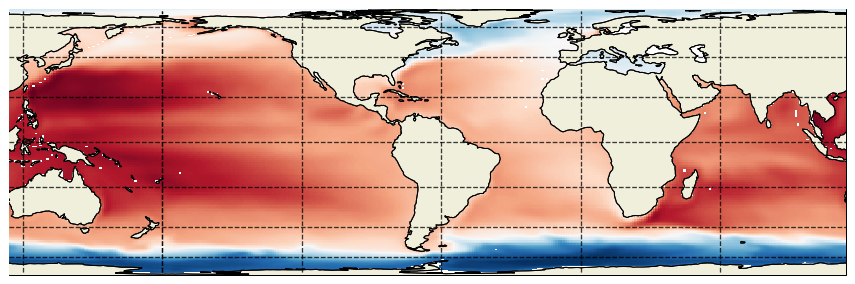

In [25]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ecco_ds.SSH.isel(time=1)
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) !=0)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC, ecco_ds.YC, \
                              tmp_plt, \
                              user_lon_0=-66,\
                              projection_type='cyl',\
                              plot_type = 'pcolormesh', \
                              dx=.25,dy=.25);

#### Polar stereographic projection

Another projection built into `plot_proj_to_latlon_grid` is polar stereographic.  The argument *lat_lim* determines the limit of this type of projection.  If *lat_lim* is postive, the projection is centered around the north pole and vice versa.

##### Northern Hemisphere

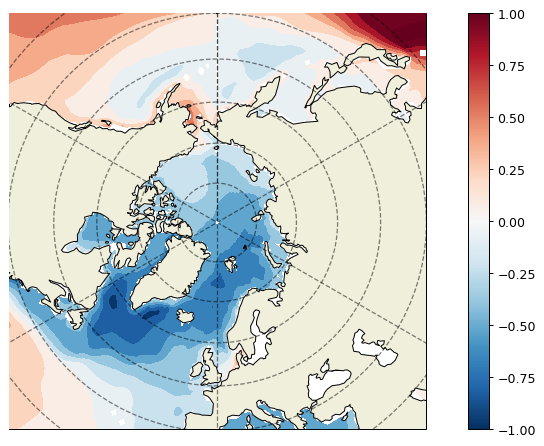

In [26]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ecco_ds.SSH.isel(time=1)
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) !=0)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC, ecco_ds.YC, \
                              tmp_plt, \
                              projection_type='stereo',\
                              plot_type = 'contourf', \
                              show_colorbar=True,
                              dx=1, dy=1,cmin=-1, cmax=1,\
                              lat_lim=40);
                            

##### Southern Hemisphere

The final example is a south-pole centered plot.  Note that *lat_lim* is now negative.

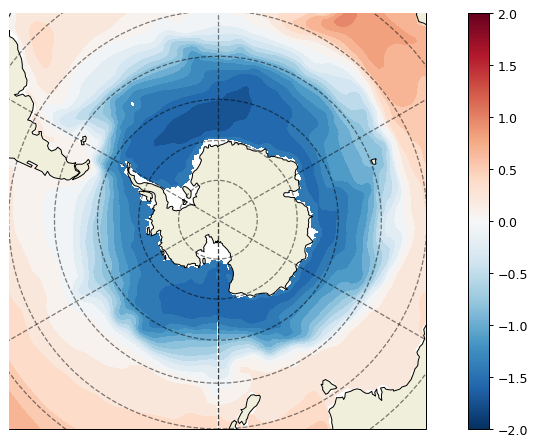

In [27]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ecco_ds.SSH.isel(time=1)
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) !=0)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC, ecco_ds.YC, \
                              tmp_plt, \
                              projection_type='stereo',\
                              plot_type = 'contourf', \
                              show_colorbar=True,
                              dx=1, dy=1,\
                              lat_lim=-40,cmin=-2,cmax=2);
                             

## Conclusion

You now know several ways of plotting ECCO state estimate fields.  There is a lot more to explore with ``Cartopy`` - dive in and start making your own cool plots!

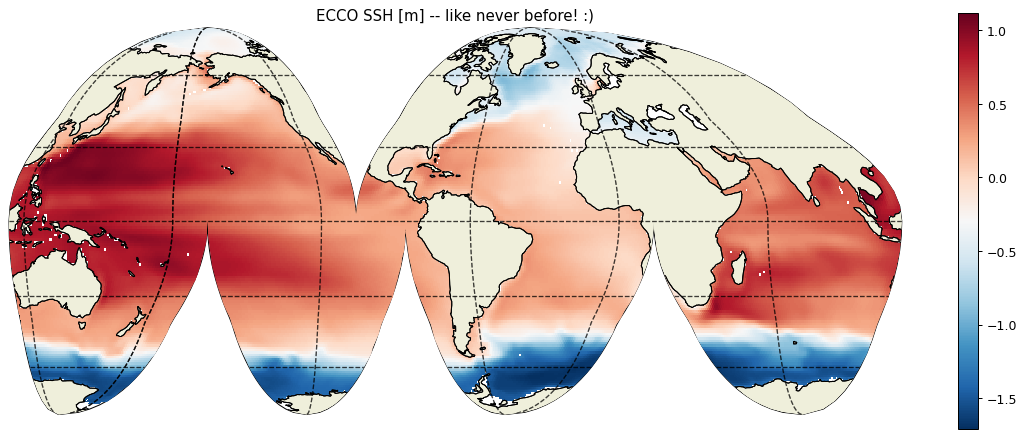

In [28]:
plt.figure(figsize=(16,6), dpi=90)

tmp_plt = ecco_ds.SSH.isel(time=1)
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) !=0)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC, ecco_ds.YC, \
                              tmp_plt, \
                              user_lon_0=-66,\
                              projection_type='InterruptedGoodeHomolosine',\
                              plot_type = 'pcolormesh', \
                              show_colorbar=True,
                              dx=1, dy=1);

plt.title('ECCO SSH [m] -- like never before! :)');